## **IA304 - Modèles probabilistes et apprentissage automatique**

### **TP - Restricted Boltzmann Machines (RBM)**

#### *Institut Polytechnique de Paris — 22 Décembre 2023*

- André PEREIRA E FERREIRA
- Ivan Luiz DE MOURA MATOS

In [7]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

---

# **Construction d'un RBM et test sur Binary AlphaDigits**

Création d'une fonction ```lire_alpha_digit``` permettant de récupérer les données sur forme matricielle (en ligne les données, en colonne les pixels), et qui prend en argument les indices des caractères que l'on souhaite apprendre:

In [100]:
def lire_alpha_digit(data_file_name, digits_list):
    """
    Fonction pour récuperer les données. Charge et organise les données alpha-digit sous forme matricielle à partir des caractères que l'on souhaite apprendre et d'un fichier MATLAB (.mat).

    Parameters:
    - data_file_name (str): Le nom du fichier .mat contenant les données alpha-digit.
    - digits_list (list): Liste des chiffres à extraire des données.

    Returns:
    - data (numpy.ndarray): Matrice contenant les données des chiffres spécifiés.
    """

    data_mat = scipy.io.loadmat(data_file_name)

    data_mat = data_mat['dat']

    data_mat = data_mat[digits_list]

    data = np.empty((data_mat.shape[0] * data_mat.shape[1], data_mat[0,0].shape[0] * data_mat[0,0].shape[1]), dtype=np.uint8)

    for i in range(data_mat.shape[0]):
        for j in range(data_mat.shape[1]):
            data[i * data_mat.shape[1] + j, :] = data_mat[i, j].flatten()

    return data

Création d'une classe ```RBM``` :

In [101]:
class RBM:
    def __init__(self, p, q):
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        self.W = np.sqrt(0.01) * np.random.randn(p, q)

    def entree_sortie(self, X):
        return 1.0 / (1.0 + np.exp(-(X @ self.W + self.b)))

    def sortie_entree(self, H):
        return 1.0 / (1.0 + np.exp(-(H @ self.W.T + self.a)))

    def train(self, X, lr=0.1, batch_size=100, nb_iter=10,
              print_all_losses=True, plot_loss=True):
        n = len(X)
        p = len(self.a)
        q = len(self.b)
        loss_list = []
        for i in range(nb_iter):
            X = X.copy()
            np.random.shuffle(X)
            for j in range(0, n, batch_size):
                X_batch = X[j:min(n, j+batch_size), :]
                taille_batch_actuelle = len(X_batch) # can be less than batch_size
                v_0 = X_batch
                p_h_v_0 = self.entree_sortie(v_0)
                h_0 = (np.random.uniform(size=(taille_batch_actuelle, q)) < p_h_v_0) * 1.0
                p_v_h_0 = self.sortie_entree(h_0)
                v_1 = (np.random.uniform(size=(taille_batch_actuelle, p)) < p_v_h_0) * 1.0
                p_h_v_1 = self.entree_sortie(v_1)
                # Computing gradients
                grad_a = np.sum(v_0 - v_1, axis=0)
                grad_b = np.sum(p_h_v_0  - p_h_v_1, axis=0)
                grad_W = v_0.T @ p_h_v_0 - v_1.T @ p_h_v_1
                # Updating parameters
                self.a = self.a + lr * grad_a / taille_batch_actuelle
                self.b = self.b + lr * grad_b / taille_batch_actuelle
                self.W = self.W + lr * grad_W / taille_batch_actuelle
            H = self.entree_sortie(X)
            X_rec = self.sortie_entree(H)    # reconstructed
            # Computing and printing the loss
            loss = np.sum((X - X_rec)**2 / n)
            loss_list.append(loss)
            if print_all_losses:
                print('Epoch: {:<5} -   Loss: {:.4f}'.format(i, loss))

        if plot_loss:
            plt.plot(loss_list)
            plt.xlabel('Époque')
            plt.ylabel('Perte')
            plt.title('Perte en fonction du nombre d\'époques (itérations)')
            plt.grid()
            plt.show()

        return loss_list

    def generer_image(self, nb_iter_gibbs, nb_images, img_shape=(20,16), generation_intermediaire=[]):
        p = len(self.a)
        q = len(self.b)
        images_intermediaires = np.zeros((nb_images, len(generation_intermediaire), p))
        images_finales = np.zeros((nb_images, p))
        for i in range(nb_images):
            v = (np.random.uniform(size=p) < np.random.uniform(size=p)) * 1.0
            for j in range(nb_iter_gibbs):
                h = (np.random.uniform(size=q) < self.entree_sortie(v)) * 1.0
                v = (np.random.uniform(size=p) < self.sortie_entree(h)) * 1.0
                if j in generation_intermediaire:
                    images_intermediaires[i, generation_intermediaire.index(j), :] = v
            images_finales[i, :] = v

        for i in range(len(generation_intermediaire)):
            plt.figure(figsize=(10,int(np.ceil(nb_images/10))))
            for j in range(nb_images):
                plt.subplot(int(np.ceil(nb_images / 10)), 10, j + 1)
                plt.imshow(images_intermediaires[j, i, :].reshape((20, 16)), cmap='gray')

                ax = plt.gca()
                for side in ["top", "bottom", "left", "right"]:
                    ax.spines[side].set_color("red")
                ax.set_xticks([])
                ax.set_yticks([])
            # plt.suptitle('Génération après {} itérations de Gibbs'.format(generation_intermediaire[i]))
            plt.show()


        plt.figure(figsize=(10,int(np.ceil(nb_images/10))))
        for i in range(nb_images):
            plt.subplot(int(np.ceil(nb_images / 10)), 10, i+1)
            plt.imshow(images_finales[i, :].reshape(img_shape), cmap='gray')

            ax = plt.gca()
            for i in ["top", "bottom", "left", "right"]:
                ax.spines[i].set_color("red")
            ax.set_xticks([])
            ax.set_yticks([])
        # plt.suptitle('Génération après {} itérations de Gibbs'.format(nb_iter_gibbs))
        plt.show()

Sélection et affichage des données d'entraînement :

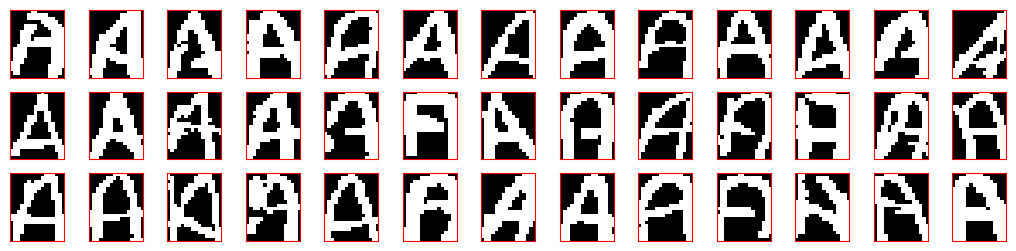

In [187]:
data = lire_alpha_digit('binaryalphadigs.mat', [10])


plt.figure(figsize=(13, len(data) // 13))
for i in range(len(data)):

    # plt.tick_params(left = False, right = False , labelleft = False ,
    #             labelbottom = False, bottom = False)

    plt.subplot(len(data) // 13, 13, i+1)
    plt.imshow(data[i,:].reshape(20,16), cmap='gray')
    # plt.axis('off')

    ax = plt.gca()
    for i in ["top", "bottom", "left", "right"]:
        ax.spines[i].set_color("red")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

Instanciation et entraînement du RBM :

Epoch: 0     -   Loss: 111.1499
Epoch: 1     -   Loss: 79.7103
Epoch: 2     -   Loss: 63.7842
Epoch: 3     -   Loss: 60.5431
Epoch: 4     -   Loss: 45.3683
Epoch: 5     -   Loss: 40.9204
Epoch: 6     -   Loss: 34.6837
Epoch: 7     -   Loss: 25.8729
Epoch: 8     -   Loss: 25.4111
Epoch: 9     -   Loss: 20.0283
Epoch: 10    -   Loss: 16.9688
Epoch: 11    -   Loss: 15.8630
Epoch: 12    -   Loss: 13.4746
Epoch: 13    -   Loss: 10.7057
Epoch: 14    -   Loss: 9.5189
Epoch: 15    -   Loss: 9.0924
Epoch: 16    -   Loss: 7.4893
Epoch: 17    -   Loss: 4.9134
Epoch: 18    -   Loss: 4.8513
Epoch: 19    -   Loss: 3.9028
Epoch: 20    -   Loss: 3.5783
Epoch: 21    -   Loss: 3.1914
Epoch: 22    -   Loss: 2.9700
Epoch: 23    -   Loss: 2.3192
Epoch: 24    -   Loss: 2.4883
Epoch: 25    -   Loss: 1.9964
Epoch: 26    -   Loss: 1.8776
Epoch: 27    -   Loss: 1.7202
Epoch: 28    -   Loss: 1.2120
Epoch: 29    -   Loss: 1.2837
Epoch: 30    -   Loss: 1.0778
Epoch: 31    -   Loss: 0.9754
Epoch: 32    -   Loss: 0.

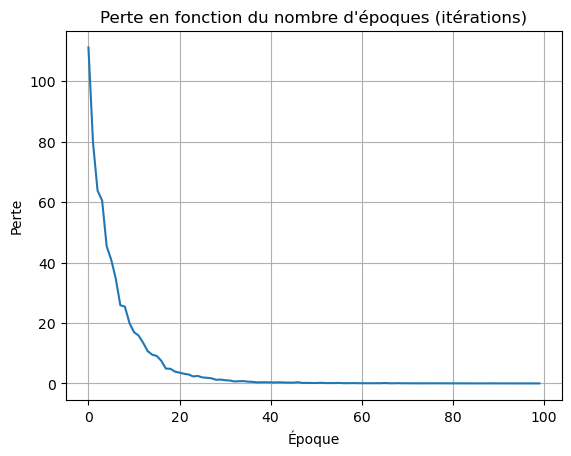

In [103]:
my_rbm = RBM(320, 10000)
_ = my_rbm.train(data, lr=0.1, batch_size=13, nb_iter=100)

Génération (réconstruction) des images :

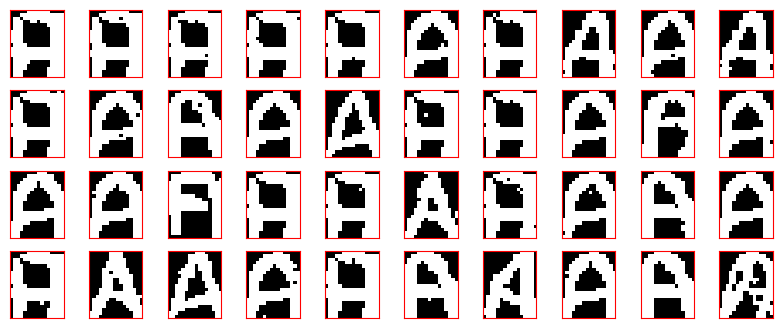

In [104]:
my_rbm.generer_image(100, 40)

---

# **Étude**

## **1. Analyser les images générées et l’erreur de reconstruction en fonction des hyperparamètres**

###  **1.1. Analyse de l'influence du nombre d'unités cachées :**


************ q = 10 unités cachées ************

Perte finale pour q = 10 : 39.2029
Images générées pour q = 10 :


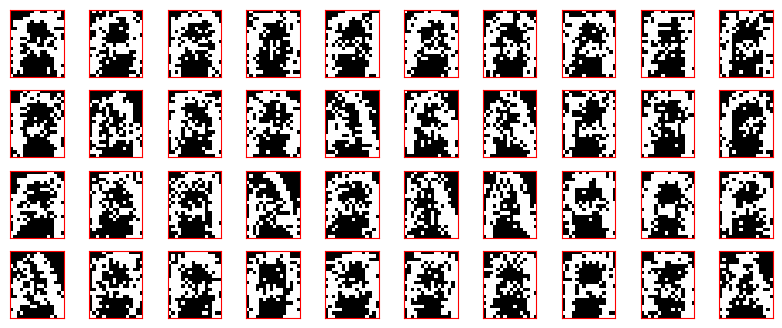


************ q = 20 unités cachées ************

Perte finale pour q = 20 : 31.3390
Images générées pour q = 20 :


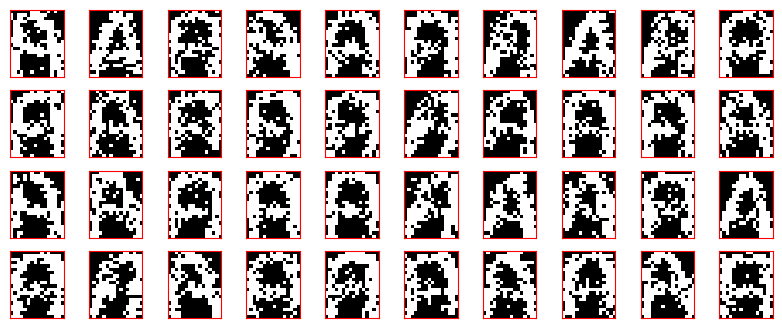


************ q = 40 unités cachées ************

Perte finale pour q = 40 : 18.8467
Images générées pour q = 40 :


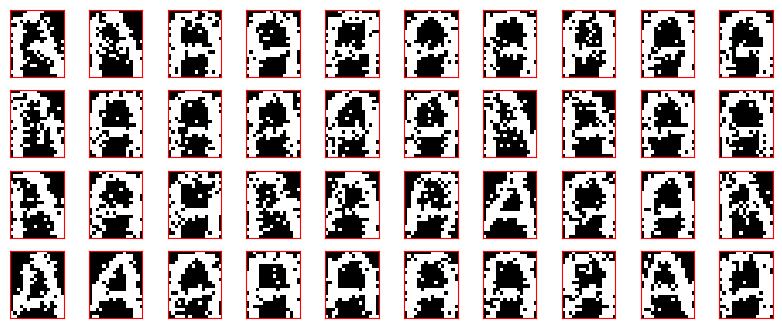


************ q = 80 unités cachées ************

Perte finale pour q = 80 : 7.2469
Images générées pour q = 80 :


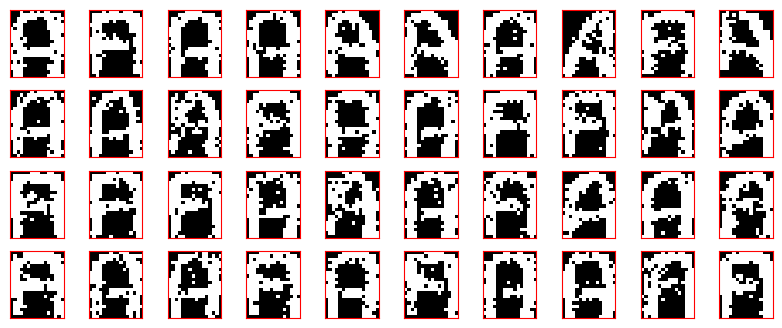


************ q = 160 unités cachées ************

Perte finale pour q = 160 : 2.0291
Images générées pour q = 160 :


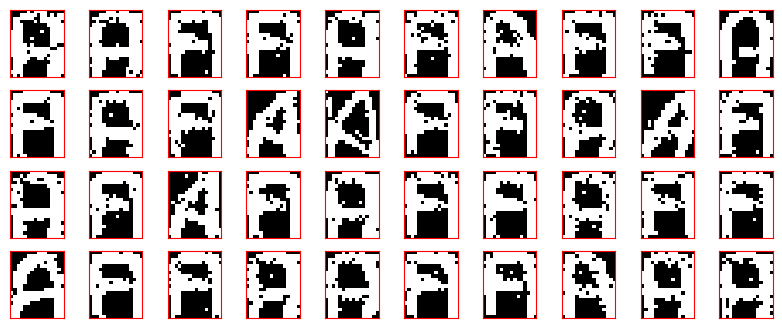


************ q = 320 unités cachées ************

Perte finale pour q = 320 : 0.5912
Images générées pour q = 320 :


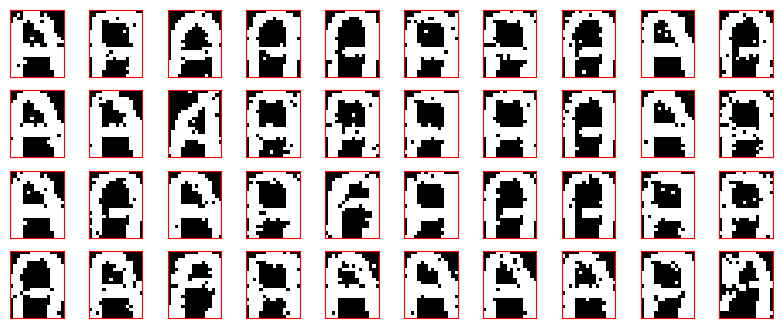


************ q = 640 unités cachées ************

Perte finale pour q = 640 : 0.1469
Images générées pour q = 640 :


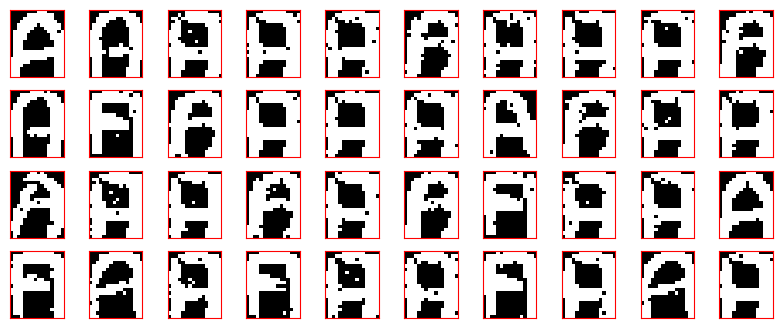


************ q = 1280 unités cachées ************

Perte finale pour q = 1280 : 0.0954
Images générées pour q = 1280 :


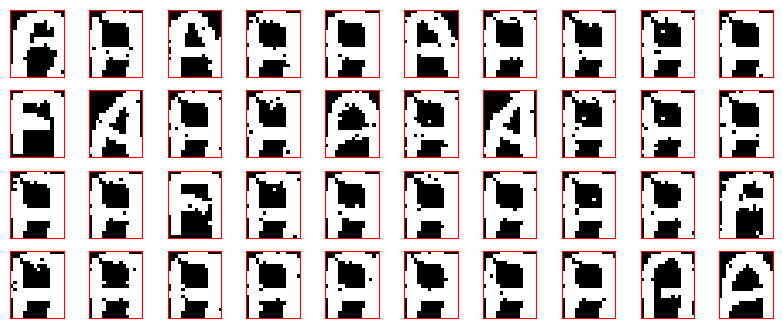


************ q = 3200 unités cachées ************

Perte finale pour q = 3200 : 0.0482
Images générées pour q = 3200 :


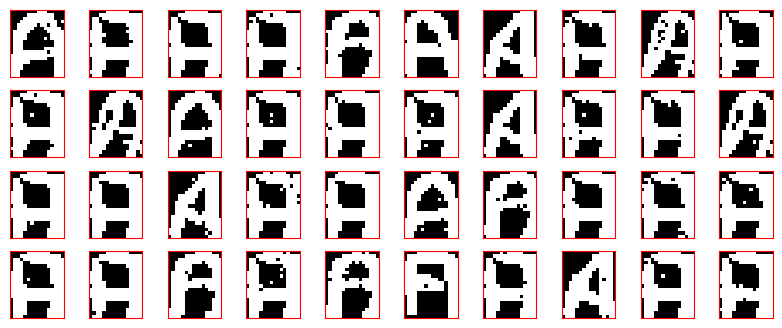


************ q = 10000 unités cachées ************

Perte finale pour q = 10000 : 0.0122
Images générées pour q = 10000 :


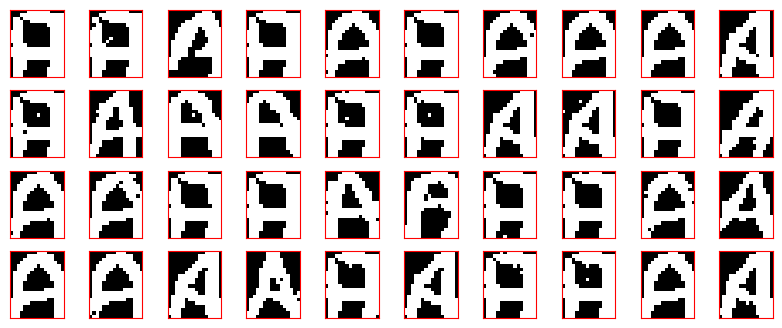

In [105]:
nb_unites_cachees = [10, 20, 40, 80, 160, 320, 640, 1280, 3200, 10000]

liste_pertes_unites_cachees = []
liste_RBM_unites_cachees = []

for q in nb_unites_cachees:
    print("\n************ q = {} unités cachées ************\n".format(q))
    my_rbm = RBM(320, q)
    loss = my_rbm.train(data, lr=0.1, batch_size=13, nb_iter=100,
                        print_all_losses=False, plot_loss=False)
    liste_pertes_unites_cachees.append(loss)
    liste_RBM_unites_cachees.append(my_rbm)
    print("Perte finale pour q = {} : {:.4f}".format(q, loss[-1]))
    print("Images générées pour q = {} :".format(q))
    my_rbm.generer_image(100, 40)

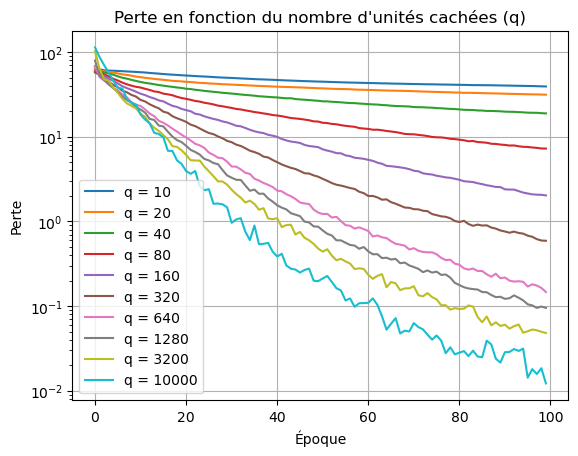

In [183]:
for i in range(len(nb_unites_cachees)):
    plt.plot(liste_pertes_unites_cachees[i], label='q = {}'.format(nb_unites_cachees[i]))
    plt.semilogy()

plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Perte en fonction du nombre d\'unités cachées (q)')
plt.grid()
plt.legend()
plt.show()

### **1.2. Analyse de l'influence du *learning rate* :**


************ Learning rate = 0.001 ************

Perte finale pour lr = 0.001 : 49.9844
Images générées pour lr = 0.001 :


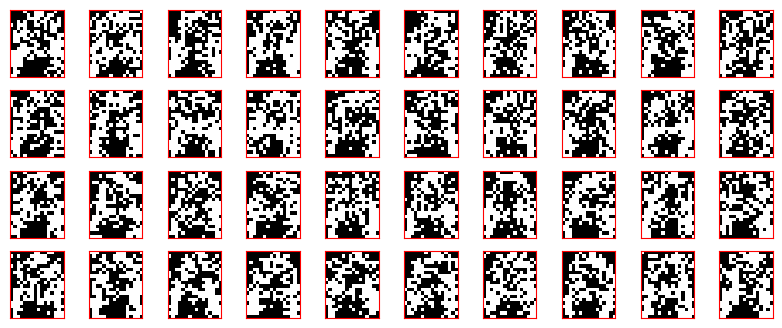


************ Learning rate = 0.01 ************

Perte finale pour lr = 0.01 : 26.6474
Images générées pour lr = 0.01 :


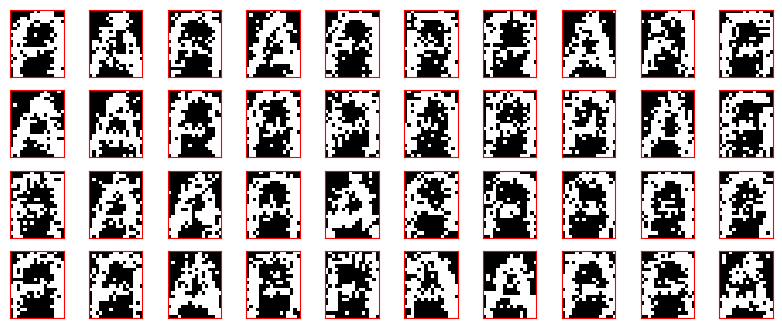


************ Learning rate = 0.05 ************

Perte finale pour lr = 0.05 : 6.2473
Images générées pour lr = 0.05 :


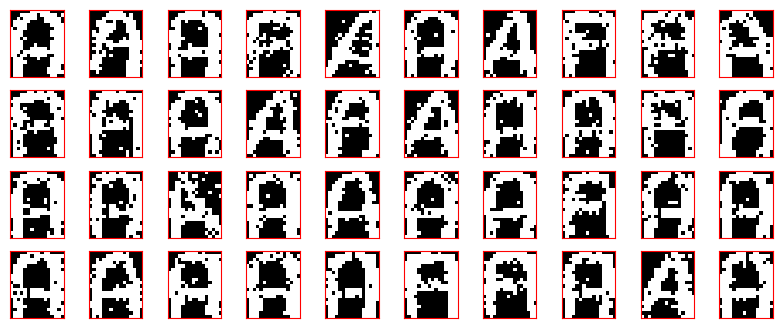


************ Learning rate = 0.1 ************

Perte finale pour lr = 0.1 : 2.0728
Images générées pour lr = 0.1 :


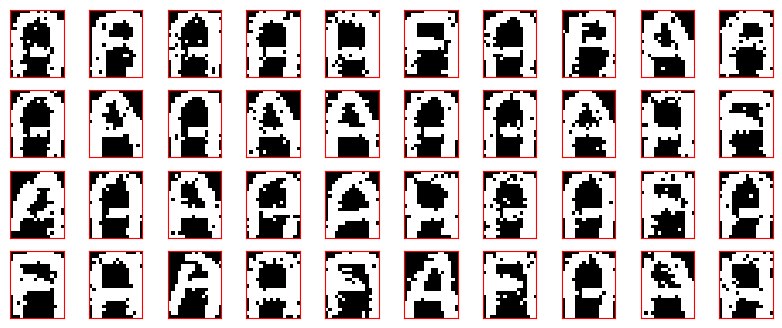


************ Learning rate = 0.25 ************

Perte finale pour lr = 0.25 : 1.2066
Images générées pour lr = 0.25 :


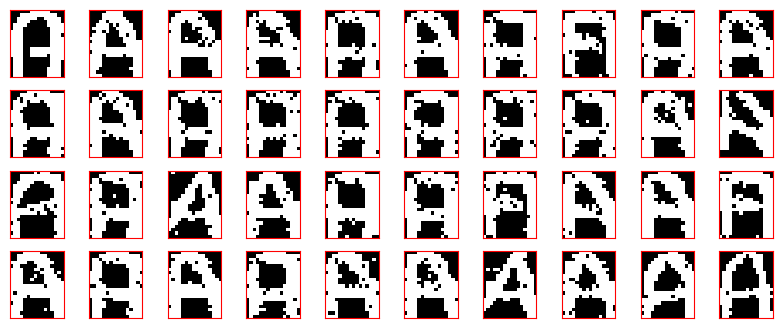


************ Learning rate = 0.5 ************

Perte finale pour lr = 0.5 : 18.6046
Images générées pour lr = 0.5 :


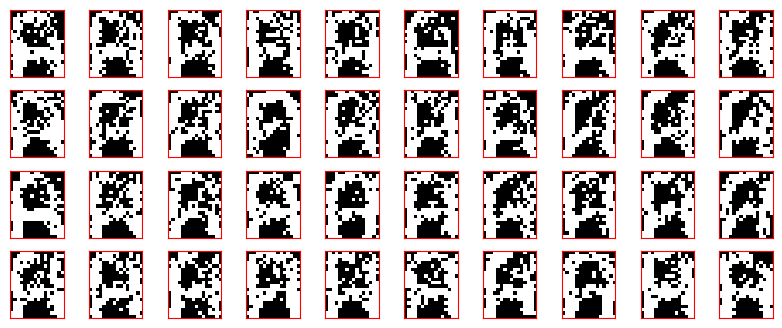


************ Learning rate = 0.75 ************

Perte finale pour lr = 0.75 : 29.3774
Images générées pour lr = 0.75 :


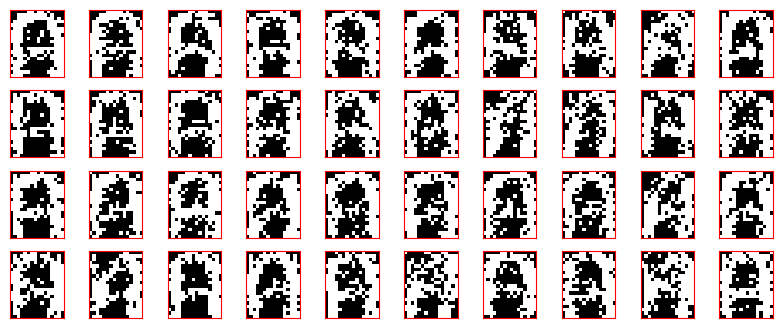


************ Learning rate = 1 ************

Perte finale pour lr = 1 : 35.0931
Images générées pour lr = 1 :


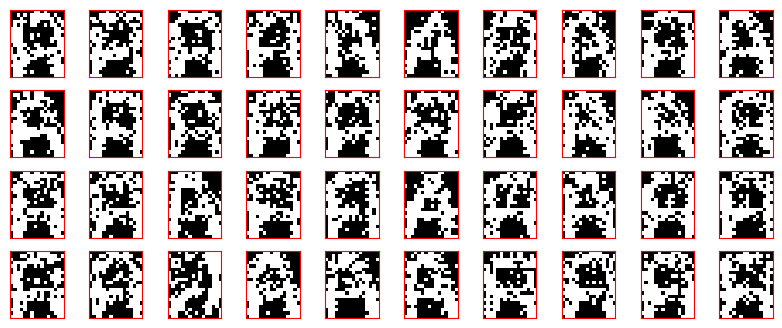

In [190]:
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]

liste_pertes_learning_rates = []
liste_RBM_learning_rates = []

for lr in learning_rates:
    print("\n************ Learning rate = {} ************\n".format(lr))
    my_rbm = RBM(320, 160)
    loss = my_rbm.train(data, lr=lr, batch_size=13, nb_iter=100,
                        print_all_losses=False, plot_loss=False)
    liste_pertes_learning_rates.append(loss)
    liste_RBM_learning_rates.append(my_rbm)
    print("Perte finale pour lr = {} : {:.4f}".format(lr, loss[-1]))
    print("Images générées pour lr = {} :".format(lr))
    my_rbm.generer_image(100, 40)

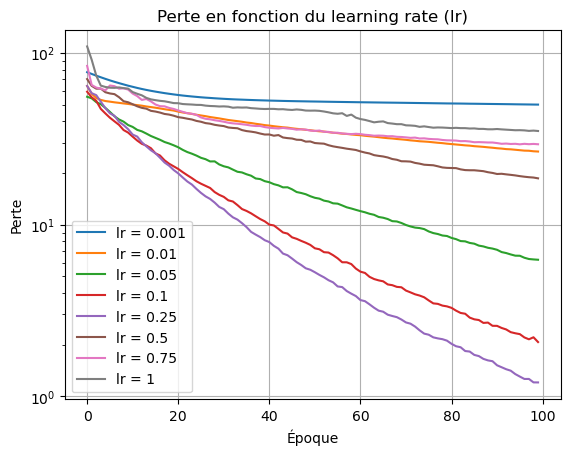

In [191]:
for i in range(len(learning_rates)):
    plt.plot(liste_pertes_learning_rates[i], label='lr = {}'.format(learning_rates[i]))
    plt.semilogy()

plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Perte en fonction du learning rate (lr)')
plt.grid()
plt.legend()
plt.show()

### **1.3. Analyse de l'influence du nombre d'itérations (nombre d'époques) :**


************ Nombre d'itérations = 1 ************

Perte finale pour nombre d'itérations = 1 : 65.1210
Images générées pour nombre d'itérations = 1 :


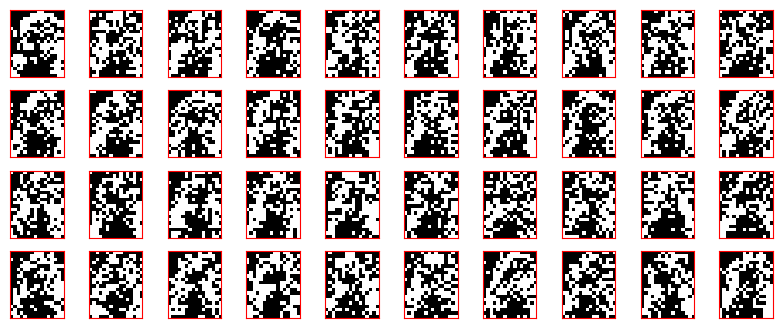


************ Nombre d'itérations = 10 ************

Perte finale pour nombre d'itérations = 10 : 44.6442
Images générées pour nombre d'itérations = 10 :


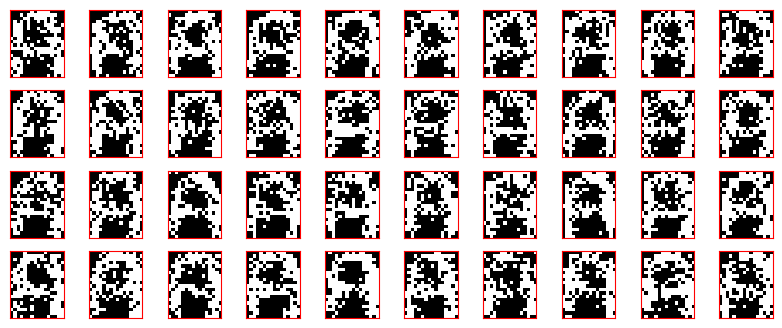


************ Nombre d'itérations = 100 ************

Perte finale pour nombre d'itérations = 100 : 1.7930
Images générées pour nombre d'itérations = 100 :


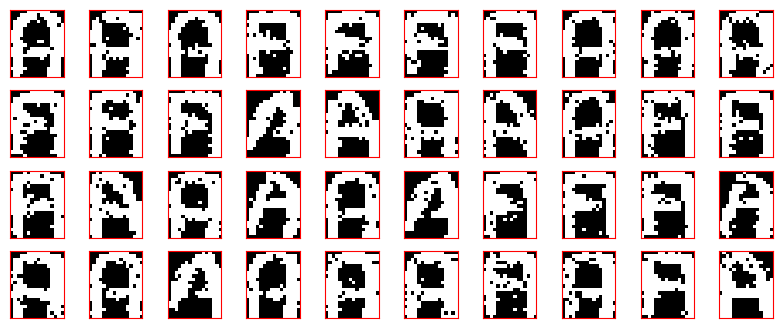


************ Nombre d'itérations = 1000 ************

Perte finale pour nombre d'itérations = 1000 : 0.0170
Images générées pour nombre d'itérations = 1000 :


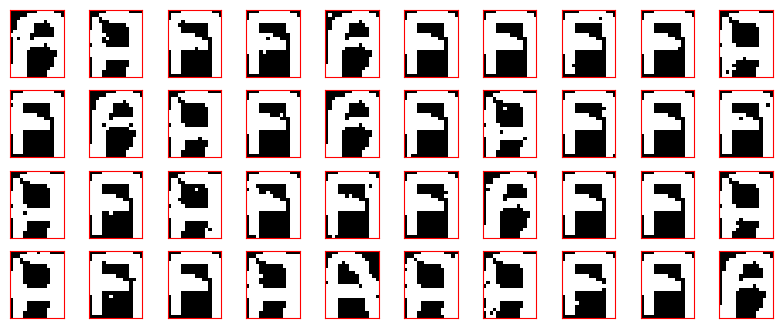


************ Nombre d'itérations = 10000 ************

Perte finale pour nombre d'itérations = 10000 : 0.0001
Images générées pour nombre d'itérations = 10000 :


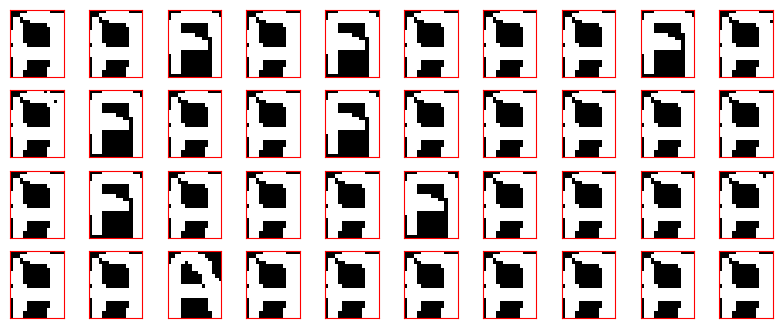

In [192]:
nb_iterations = [1, 10, 100, 1000, 10000]

liste_pertes_nb_iterations = []
liste_RBM_nb_iterations = []

for nb_iter in nb_iterations:
    print("\n************ Nombre d'itérations = {} ************\n".format(nb_iter))
    my_rbm = RBM(320, 160)
    loss = my_rbm.train(data, lr=0.25, batch_size=13, nb_iter=nb_iter,
                        print_all_losses=False, plot_loss=False)
    liste_pertes_nb_iterations.append(loss)
    liste_RBM_nb_iterations.append(my_rbm)
    print("Perte finale pour nombre d'itérations = {} : {:.4f}".format(nb_iter, loss[-1]))
    print("Images générées pour nombre d'itérations = {} :".format(nb_iter))
    my_rbm.generer_image(100, 40)

### **1.4. Analyse de l'influence du *batch size* :**


************ Batch size = 1 ************

Perte finale pour batch size = 1 : 0.0085
Images générées pour batch size = 1 :


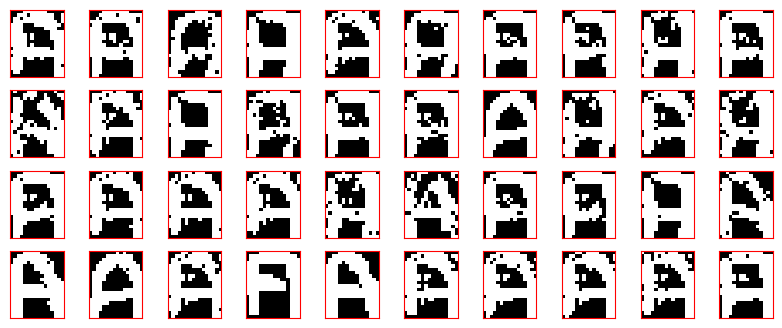


************ Batch size = 3 ************

Perte finale pour batch size = 3 : 0.0078
Images générées pour batch size = 3 :


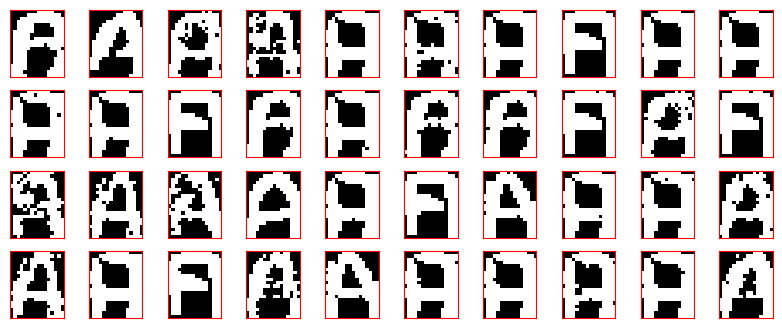


************ Batch size = 7 ************

Perte finale pour batch size = 7 : 0.0070
Images générées pour batch size = 7 :


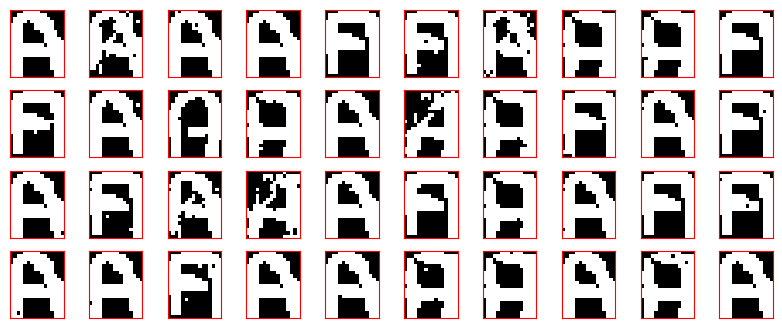


************ Batch size = 13 ************

Perte finale pour batch size = 13 : 0.0085
Images générées pour batch size = 13 :


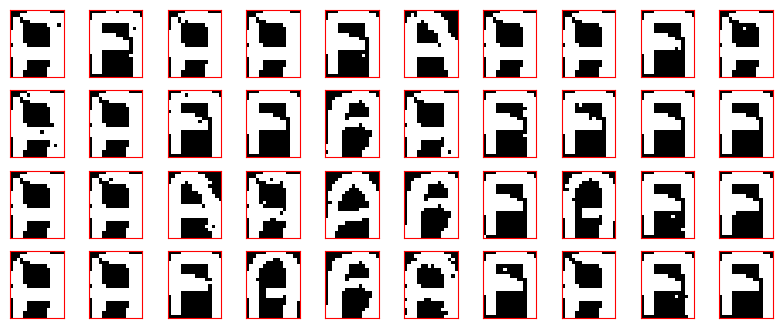


************ Batch size = 25 ************

Perte finale pour batch size = 25 : 0.0114
Images générées pour batch size = 25 :


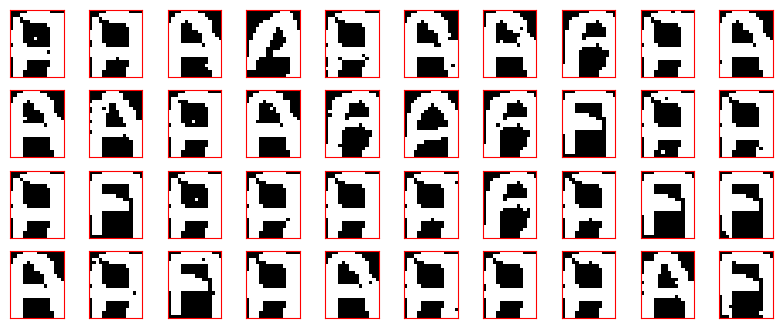


************ Batch size = 39 ************

Perte finale pour batch size = 39 : 0.0346
Images générées pour batch size = 39 :


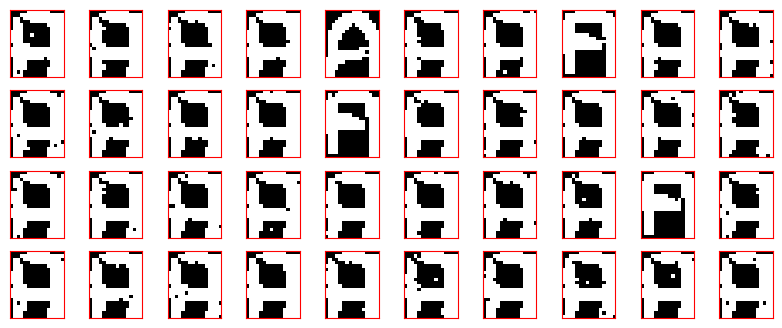

In [110]:
batch_sizes = [1, 3, 7, 13, 25, 39]

liste_pertes_batch_sizes = []
liste_RBM_batch_sizes = []

for batch_size in batch_sizes:
    print("\n************ Batch size = {} ************\n".format(batch_size))
    my_rbm = RBM(320, 160)
    loss = my_rbm.train(data, lr=0.25, batch_size=batch_size, nb_iter=1000,
                        print_all_losses=False, plot_loss=False)
    liste_pertes_batch_sizes.append(loss)
    liste_RBM_batch_sizes.append(my_rbm)
    print("Perte finale pour batch size = {} : {:.4f}".format(batch_size, loss[-1]))
    print("Images générées pour batch size = {} :".format(batch_size))
    my_rbm.generer_image(100, 40)

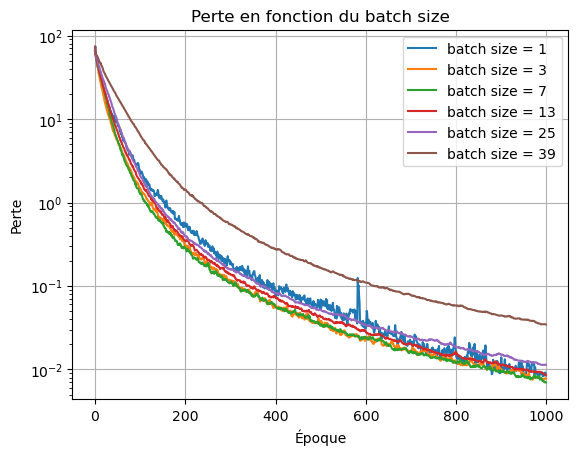

In [111]:
for i in range(len(batch_sizes)):
    plt.plot(liste_pertes_batch_sizes[i], label='batch size = {}'.format(batch_sizes[i]))
    plt.semilogy()

plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Perte en fonction du batch size')
plt.grid()
plt.legend()
plt.show()

### **1.5. Analyse de l'influence du nombre d'itérations de Gibbs :**


************ Nombre d'itérations de Gibbs = 1 ************

Images générées pour nombre d'itérations de Gibbs = 1 :


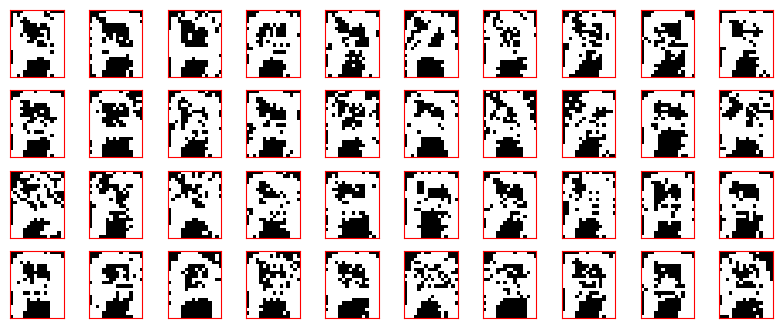


************ Nombre d'itérations de Gibbs = 10 ************

Images générées pour nombre d'itérations de Gibbs = 10 :


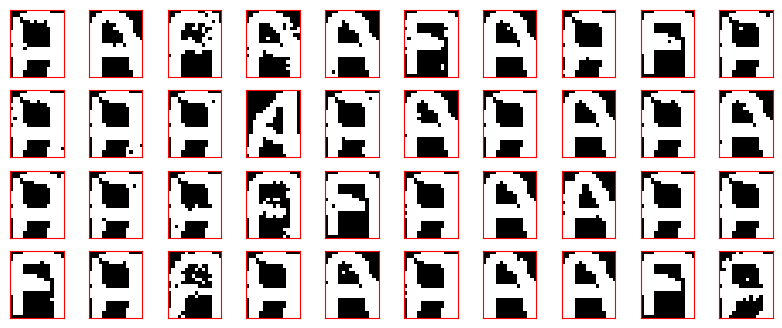


************ Nombre d'itérations de Gibbs = 50 ************

Images générées pour nombre d'itérations de Gibbs = 50 :


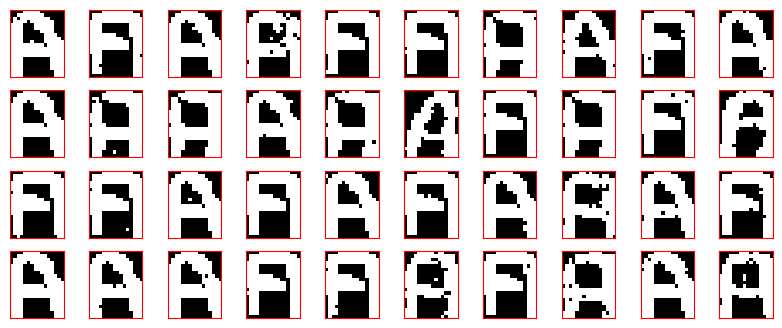


************ Nombre d'itérations de Gibbs = 100 ************

Images générées pour nombre d'itérations de Gibbs = 100 :


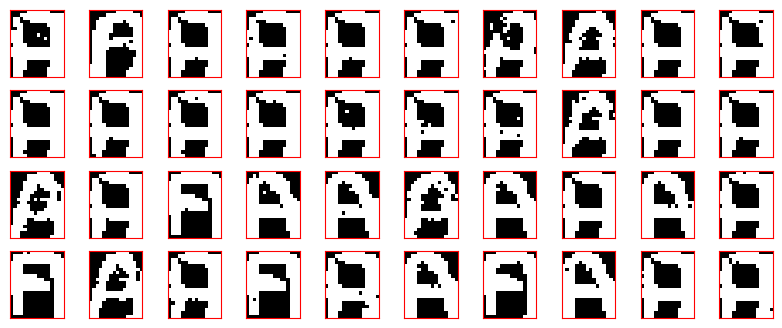


************ Nombre d'itérations de Gibbs = 500 ************

Images générées pour nombre d'itérations de Gibbs = 500 :


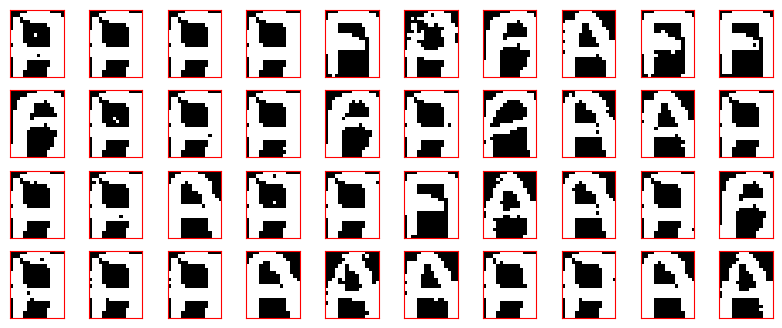


************ Nombre d'itérations de Gibbs = 1000 ************

Images générées pour nombre d'itérations de Gibbs = 1000 :


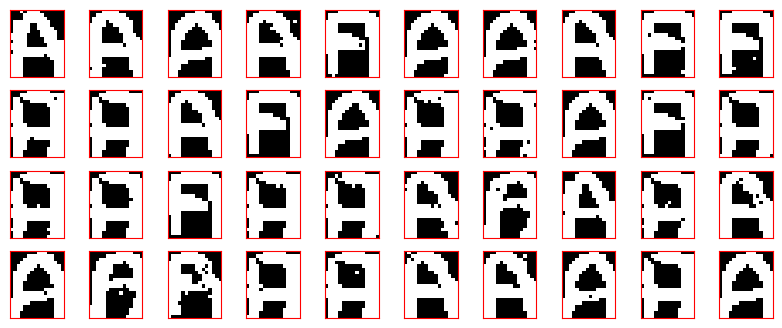

In [193]:
nb_iterations_gibbs = [1, 10, 50, 100, 500, 1000]

liste_pertes_iter_gibbs = []
liste_RBM_iter_gibbs = []

for nb_iter_gibbs in nb_iterations_gibbs:
    print("\n************ Nombre d'itérations de Gibbs = {} ************\n".format(nb_iter_gibbs))
    my_rbm = RBM(320, 160)
    loss = my_rbm.train(data, lr=0.25, batch_size=13, nb_iter=1000,
                        print_all_losses=False, plot_loss=False)
    liste_pertes_iter_gibbs.append(loss)
    liste_RBM_iter_gibbs.append(my_rbm)
    # print("Perte finale pour nombre d'itérations de Gibbs = {} : {:.4f}".format(nb_iter_gibbs, loss[-1]))
    print("Images générées pour nombre d'itérations de Gibbs = {} :".format(nb_iter_gibbs))
    my_rbm.generer_image(nb_iter_gibbs, 40)

### **1.6. Tests avec d'autres caractères :**

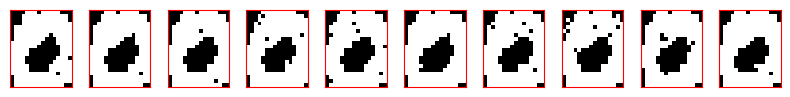

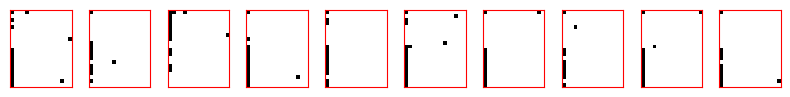

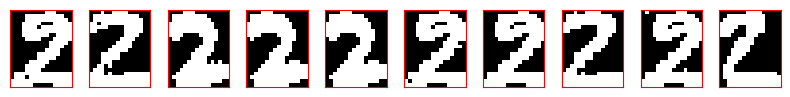

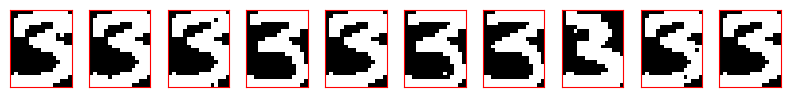

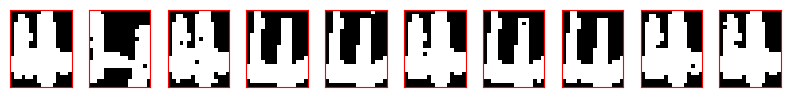

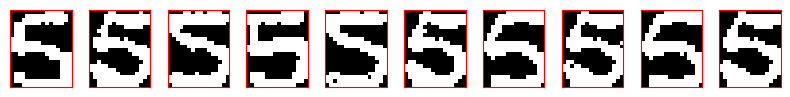

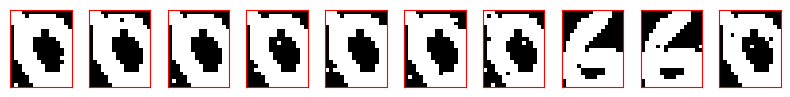

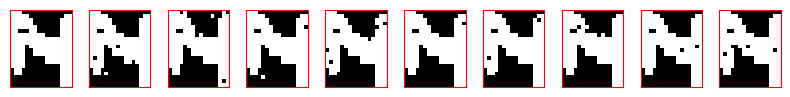

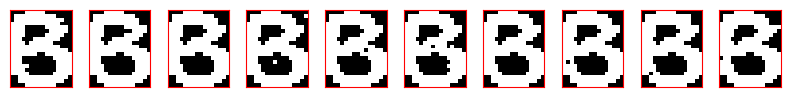

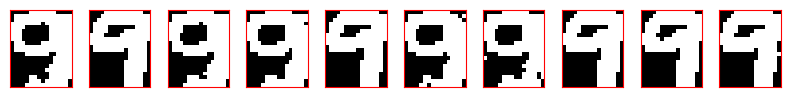

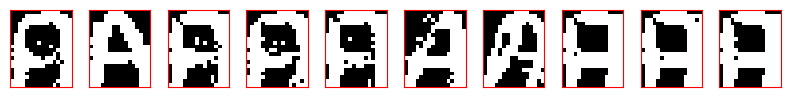

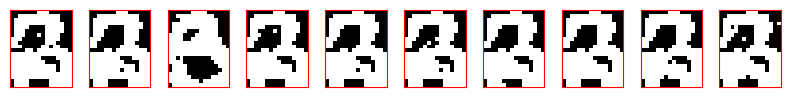

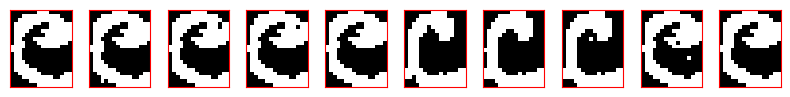

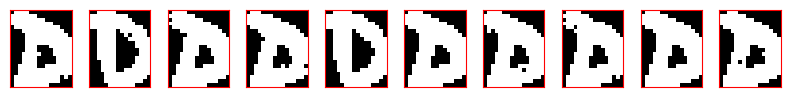

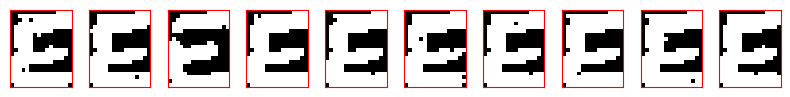

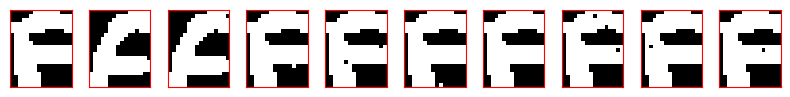

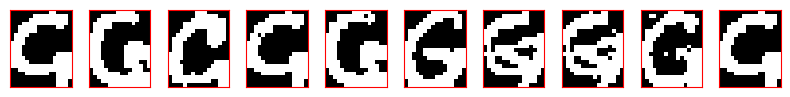

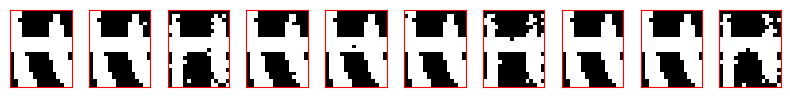

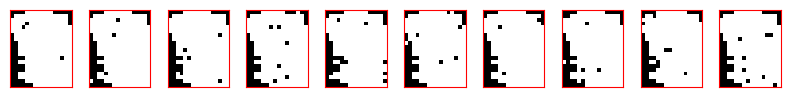

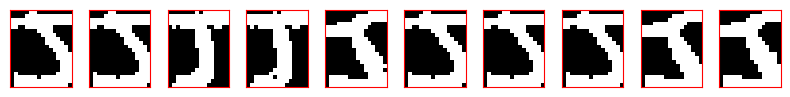

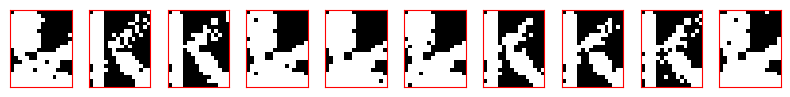

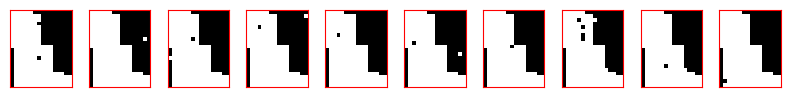

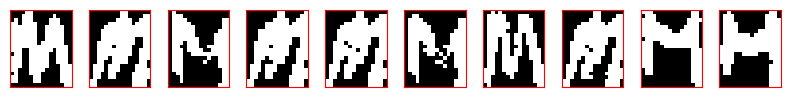

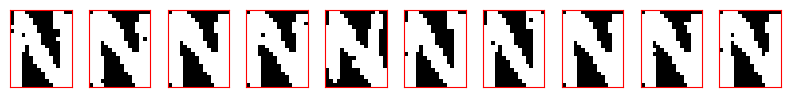

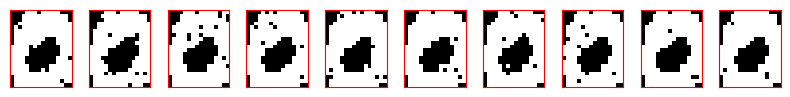

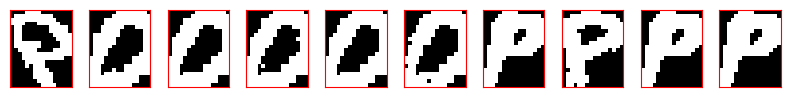

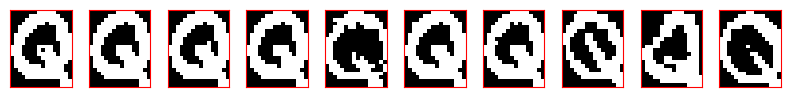

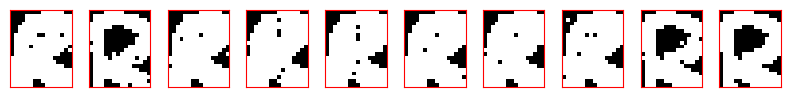

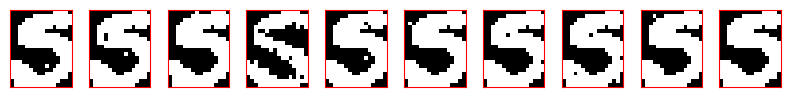

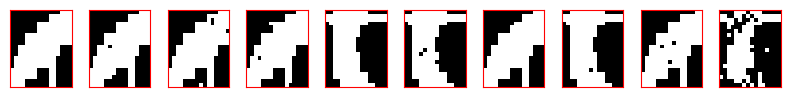

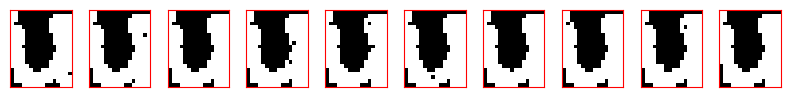

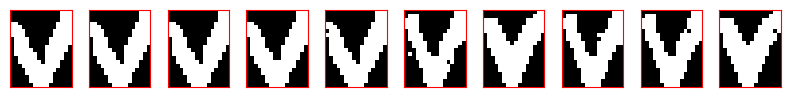

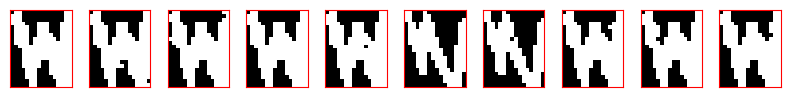

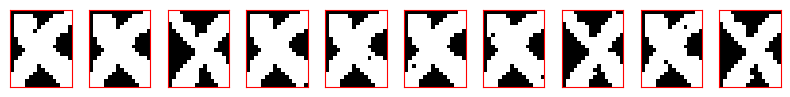

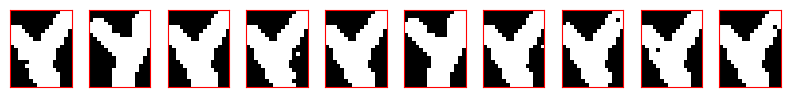

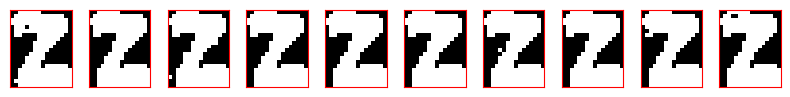

In [116]:
# Nous générons et affichons 10 images pour chaque caractère
for caractere in list(range(36)):
    my_rbm = RBM(320, 160)

    data = lire_alpha_digit('binaryalphadigs.mat', [caractere])

    loss = my_rbm.train(data, lr=0.25, batch_size=13, nb_iter=1000,
                        print_all_losses=False, plot_loss=False)

    # print("Perte finale : {:.4f}".format(loss[-1]))
    # print("Images générées :")
    my_rbm.generer_image(100, 10)

## **2. Analyser le pouvoir modélisant du modèle en fonction du nombre de caractères à apprendre (A, puis (A, B), puis (A, B, C), …)**


### **2.1 Entraînement avec les caractères "A" et "B"**


Perte finale : 0.0117
Images générées :


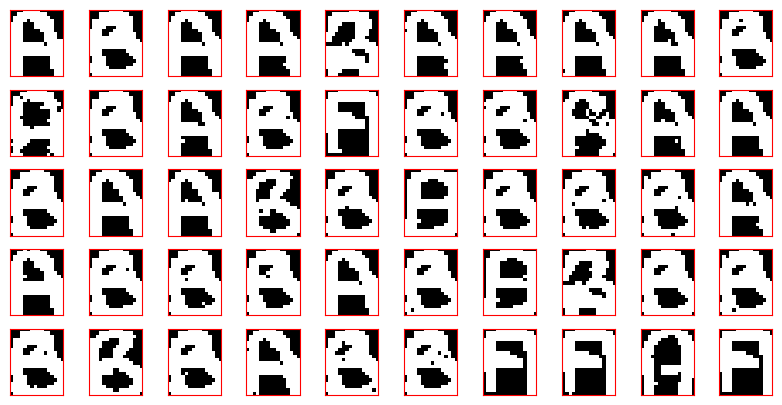

In [65]:
my_rbm = RBM(320, 160)

data = lire_alpha_digit('binaryalphadigs.mat', [10,11])

loss = my_rbm.train(data, lr=0.25, batch_size=13, nb_iter=1000,
                    print_all_losses=False, plot_loss=False)

print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50)

### **2.2 Entraînement avec les caractères "A", "B" et "C"**

Perte finale : 0.0414
Images générées :


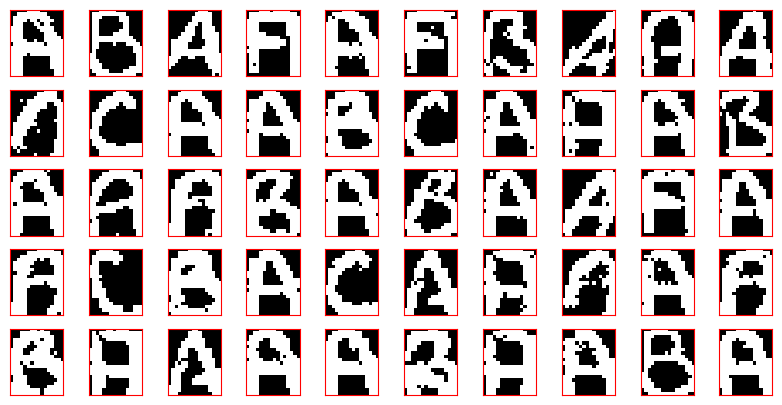

In [83]:
my_rbm = RBM(320, 1000)

data = lire_alpha_digit('binaryalphadigs.mat', [10,11,12])

loss = my_rbm.train(data, lr=0.01, batch_size=39, nb_iter=2000,
                    print_all_losses=False, plot_loss=False)

print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50)

### **2.3 Entraînement avec les caractères "A", "B", "C" et "D"**

Perte finale : 0.0002
Images générées :


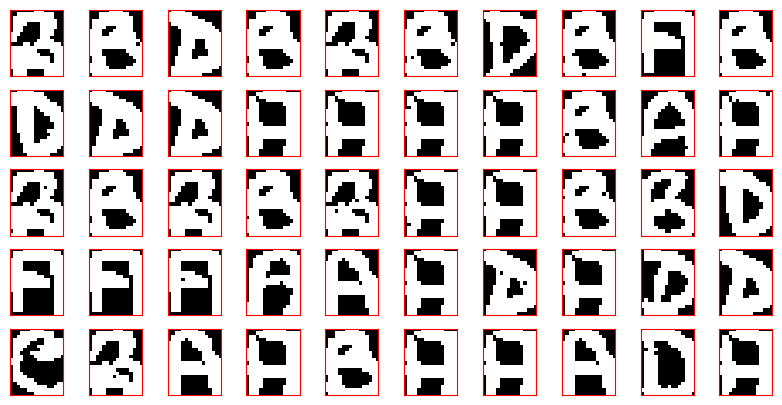

In [86]:
my_rbm = RBM(320, 1000)

data = lire_alpha_digit('binaryalphadigs.mat', [10,11,12,13])

loss = my_rbm.train(data, lr=0.1, batch_size=39, nb_iter=2000,
                    print_all_losses=False, plot_loss=False)

print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50)

### **2.4 Entraînement avec les caractères "A", "B", "C", "D" et "E"**

Perte finale : 0.0395
Images générées :


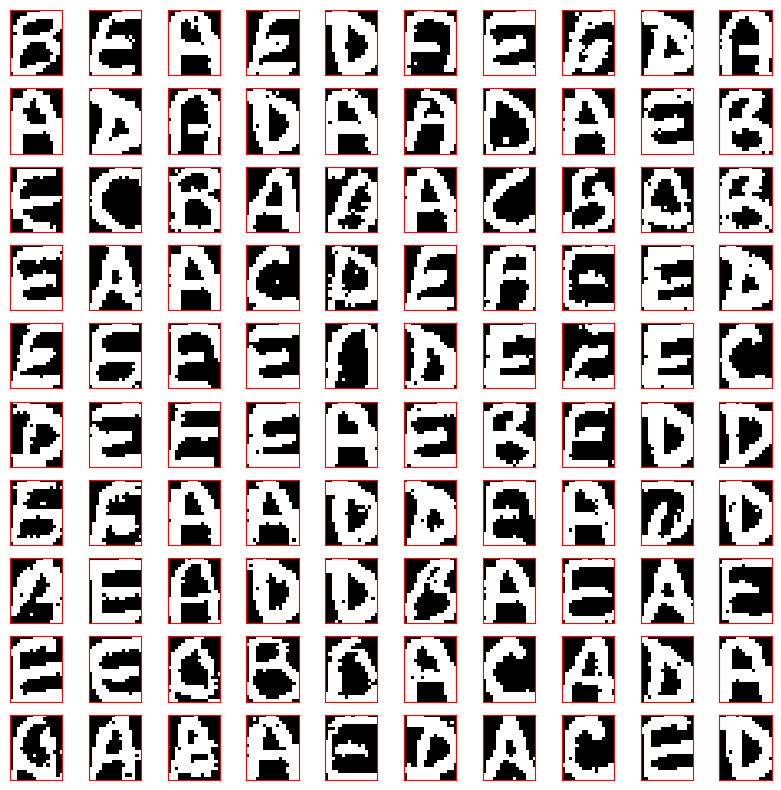

In [ ]:
my_rbm = RBM(320, 1000)

data = lire_alpha_digit('binaryalphadigs.mat', [10,11,12,13,14])

loss = my_rbm.train(data, lr=0.01, batch_size=40, nb_iter=2000,
                    print_all_losses=False, plot_loss=False)

print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 100)

## **3. Essayer le modèle sur des bases de données alternatives (MNIST, …), en pensant à binariser les données (0 et 1)**


### **3.1 MNIST :**

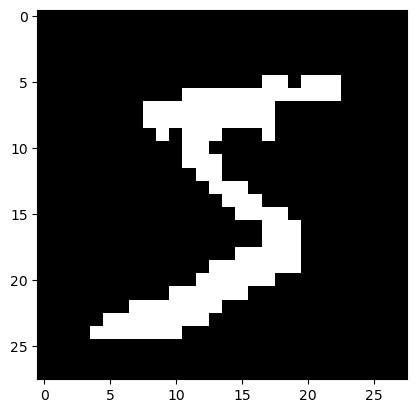

In [117]:
from keras.datasets import mnist

(train_X, train_y), _ = mnist.load_data()

plt.imshow(train_X[0] >= 128, cmap='gray')
plt.show()

Fonction pour sélectioner les images du jeu de données MNIST, selon les caractères souhaités :

In [118]:
def select_mnist_data(digits_list, limit_digit_samples=None):

    (train_X, train_y), _ = mnist.load_data()

    mnist_selected_data = []

    # Sélection des images correspondant aux chiffres souhaités
    for digit in digits_list:
        digit_data = list(train_X[train_y == digit])
        np.random.shuffle(digit_data)
        mnist_selected_data.extend(digit_data[:limit_digit_samples])

    #"Flattening" des images
    for i in range(len(mnist_selected_data)):
        mnist_selected_data[i] = (mnist_selected_data[i].flatten() > 128) * 1.0

    return np.array(mnist_selected_data)

Affichage de quelques images sélectionnées :

Images séléctionnées :



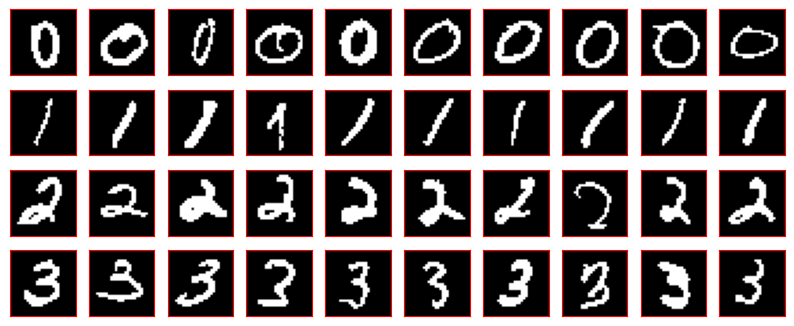


Nombre total d'images séléctionnées : 40


In [122]:
mnist_selected_data = select_mnist_data(digits_list=[0,1,2,3], limit_digit_samples=10)

plt.figure(figsize=(10, 4))

for i in range(40):

    plt.subplot(4, 10, i+1)
    plt.imshow(mnist_selected_data[i].reshape(28,28), cmap='gray')

    ax = plt.gca()
    for i in ["top", "bottom", "left", "right"]:
        ax.spines[i].set_color("red")
    ax.set_xticks([])
    ax.set_yticks([])

print("Images séléctionnées :\n")

plt.show()

print("\nNombre total d'images séléctionnées : {}".format(len(mnist_selected_data)))

#### **3.1.1 Apprentissage isolé des caractères “0”, “1” et “2”**

**Apprentissage du caractère "0"**

Entraînement du RBM à partir des images du dataset MNIST sélectionnées :

In [143]:
mnist_selected_data = select_mnist_data(digits_list=[0], limit_digit_samples=1000)

my_rbm = RBM(784, 1000)

loss = my_rbm.train(mnist_selected_data, lr=0.1, batch_size=50, nb_iter=200,
                    print_all_losses=True, plot_loss=False)

Epoch: 0     -   Loss: 30.9880
Epoch: 1     -   Loss: 26.1544
Epoch: 2     -   Loss: 22.3458
Epoch: 3     -   Loss: 19.7513
Epoch: 4     -   Loss: 18.4561
Epoch: 5     -   Loss: 17.0276
Epoch: 6     -   Loss: 16.0918
Epoch: 7     -   Loss: 15.0768
Epoch: 8     -   Loss: 14.6620
Epoch: 9     -   Loss: 13.7803
Epoch: 10    -   Loss: 13.2149
Epoch: 11    -   Loss: 12.7678
Epoch: 12    -   Loss: 12.3489
Epoch: 13    -   Loss: 12.1182
Epoch: 14    -   Loss: 11.5877
Epoch: 15    -   Loss: 11.2266
Epoch: 16    -   Loss: 10.8372
Epoch: 17    -   Loss: 10.5381
Epoch: 18    -   Loss: 10.2388
Epoch: 19    -   Loss: 10.0630
Epoch: 20    -   Loss: 9.7422
Epoch: 21    -   Loss: 9.4822
Epoch: 22    -   Loss: 9.1917
Epoch: 23    -   Loss: 9.0735
Epoch: 24    -   Loss: 8.7314
Epoch: 25    -   Loss: 8.5520
Epoch: 26    -   Loss: 8.2563
Epoch: 27    -   Loss: 8.1108
Epoch: 28    -   Loss: 7.9015
Epoch: 29    -   Loss: 7.6254
Epoch: 30    -   Loss: 7.5698
Epoch: 31    -   Loss: 7.4296
Epoch: 32    -   Los

Perte finale : 0.2570
Images générées :


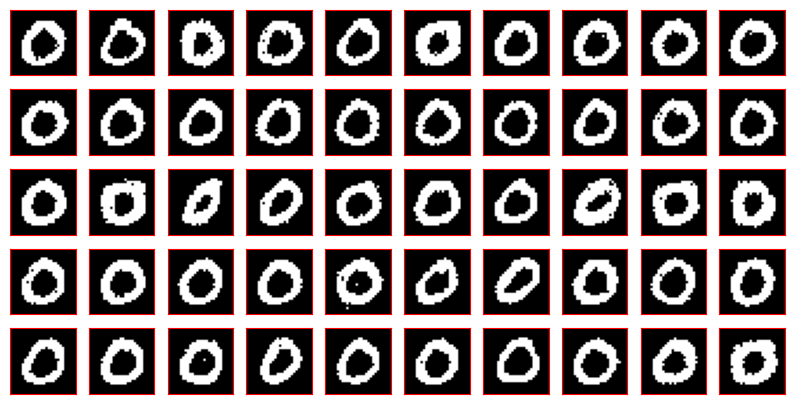

In [144]:
print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

**Apprentissage du caractère "1"**

In [141]:
mnist_selected_data = select_mnist_data(digits_list=[1], limit_digit_samples=1000)

my_rbm = RBM(784, 1000)

loss = my_rbm.train(mnist_selected_data, lr=0.1, batch_size=50, nb_iter=200,
                    print_all_losses=True, plot_loss=False)

Perte finale : 0.5115
Images générées :


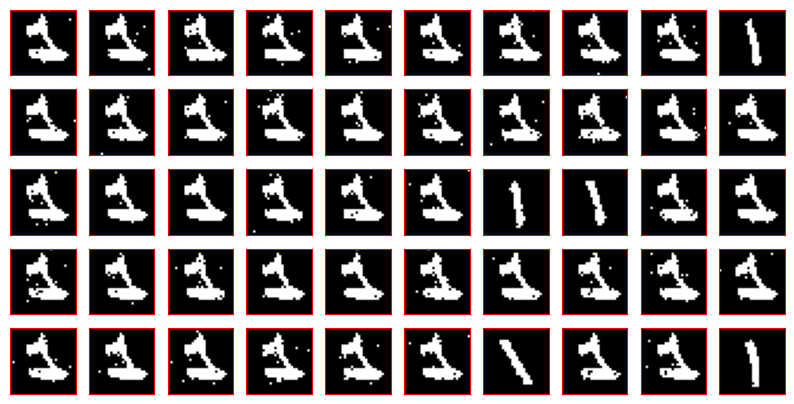

In [142]:
print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

**Apprentissage du caractère "2"**

In [147]:
mnist_selected_data = select_mnist_data(digits_list=[2], limit_digit_samples=1000)

my_rbm = RBM(784, 1000)

loss = my_rbm.train(mnist_selected_data, lr=0.1, batch_size=50, nb_iter=200,
                    print_all_losses=True, plot_loss=False)

Epoch: 0     -   Loss: 38.6124
Epoch: 1     -   Loss: 28.2545
Epoch: 2     -   Loss: 24.9056
Epoch: 3     -   Loss: 22.0427
Epoch: 4     -   Loss: 20.2837
Epoch: 5     -   Loss: 18.4007
Epoch: 6     -   Loss: 17.4621
Epoch: 7     -   Loss: 16.3428
Epoch: 8     -   Loss: 15.3245
Epoch: 9     -   Loss: 14.4593
Epoch: 10    -   Loss: 13.9404
Epoch: 11    -   Loss: 13.2691
Epoch: 12    -   Loss: 12.6442
Epoch: 13    -   Loss: 12.3213
Epoch: 14    -   Loss: 11.8931
Epoch: 15    -   Loss: 11.2473
Epoch: 16    -   Loss: 10.6480
Epoch: 17    -   Loss: 10.5618
Epoch: 18    -   Loss: 10.0545
Epoch: 19    -   Loss: 9.6336
Epoch: 20    -   Loss: 9.3016
Epoch: 21    -   Loss: 9.1324
Epoch: 22    -   Loss: 8.9615
Epoch: 23    -   Loss: 8.6235
Epoch: 24    -   Loss: 8.3865
Epoch: 25    -   Loss: 8.0109
Epoch: 26    -   Loss: 7.8170
Epoch: 27    -   Loss: 7.6391
Epoch: 28    -   Loss: 7.4322
Epoch: 29    -   Loss: 7.0889
Epoch: 30    -   Loss: 7.0201
Epoch: 31    -   Loss: 6.7587
Epoch: 32    -   Loss

Perte finale : 0.1460
Images générées :


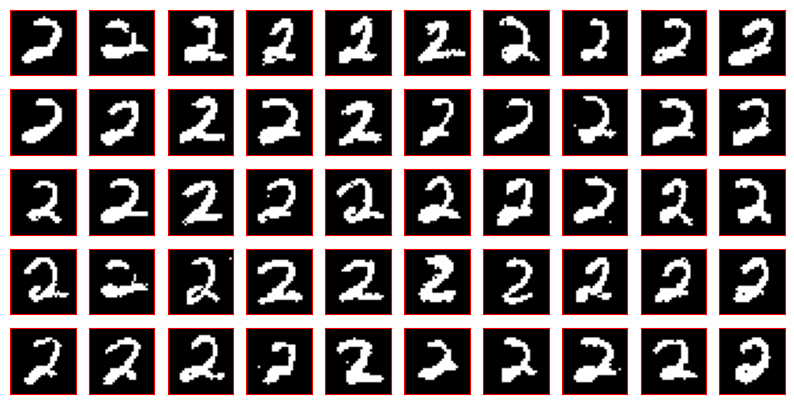

In [149]:
print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

#### **3.1.2 Apprentissage des groupes de caractères : {0, 2} et {1, 2}**

**Apprentissage des caractères "0" et "2"**

In [157]:
mnist_selected_data = select_mnist_data(digits_list=[0, 2], limit_digit_samples=1000)

my_rbm = RBM(784, 1000)

loss = my_rbm.train(mnist_selected_data, lr=0.1, batch_size=100, nb_iter=200 ,
                    print_all_losses=True, plot_loss=False)

Epoch: 0     -   Loss: 32.8465
Epoch: 1     -   Loss: 26.8409
Epoch: 2     -   Loss: 23.3815
Epoch: 3     -   Loss: 20.9017
Epoch: 4     -   Loss: 19.9123
Epoch: 5     -   Loss: 18.0653
Epoch: 6     -   Loss: 17.0682
Epoch: 7     -   Loss: 16.0708
Epoch: 8     -   Loss: 15.3500
Epoch: 9     -   Loss: 14.6700
Epoch: 10    -   Loss: 14.0037
Epoch: 11    -   Loss: 13.6143
Epoch: 12    -   Loss: 13.2397
Epoch: 13    -   Loss: 12.8164
Epoch: 14    -   Loss: 12.4562
Epoch: 15    -   Loss: 12.0564
Epoch: 16    -   Loss: 11.7416
Epoch: 17    -   Loss: 11.3429
Epoch: 18    -   Loss: 11.1028
Epoch: 19    -   Loss: 10.8315
Epoch: 20    -   Loss: 10.7372
Epoch: 21    -   Loss: 10.4101
Epoch: 22    -   Loss: 10.1640
Epoch: 23    -   Loss: 10.0662
Epoch: 24    -   Loss: 9.7161
Epoch: 25    -   Loss: 9.5114
Epoch: 26    -   Loss: 9.4183
Epoch: 27    -   Loss: 9.1435
Epoch: 28    -   Loss: 9.1384
Epoch: 29    -   Loss: 8.8369
Epoch: 30    -   Loss: 8.7694
Epoch: 31    -   Loss: 8.5676
Epoch: 32    -  

Perte finale : 0.9799
Images générées :


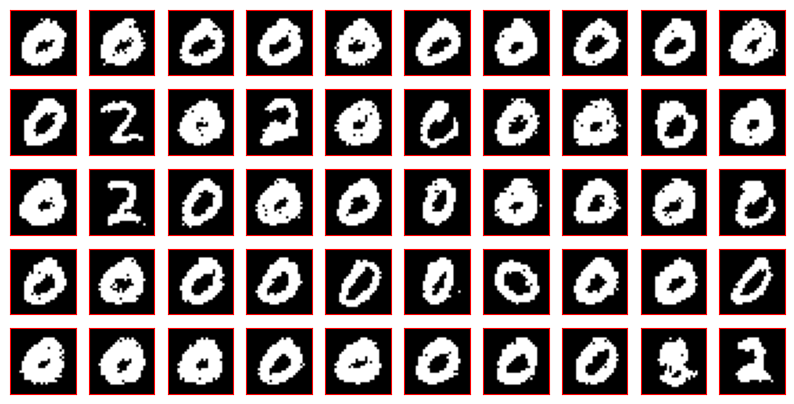

In [158]:
print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

**Apprentissage des caractères "1" et "2"**

In [162]:
mnist_selected_data = select_mnist_data(digits_list=[1, 2], limit_digit_samples=1000)

my_rbm = RBM(784, 1200)

loss = my_rbm.train(mnist_selected_data, lr=0.1, batch_size=100, nb_iter=200 ,
                    print_all_losses=True, plot_loss=False)

Epoch: 0     -   Loss: 22.5971
Epoch: 1     -   Loss: 17.7884
Epoch: 2     -   Loss: 15.5473
Epoch: 3     -   Loss: 13.7502
Epoch: 4     -   Loss: 12.4372
Epoch: 5     -   Loss: 11.7685
Epoch: 6     -   Loss: 10.9966
Epoch: 7     -   Loss: 10.5361
Epoch: 8     -   Loss: 10.0693
Epoch: 9     -   Loss: 9.4887
Epoch: 10    -   Loss: 9.2198
Epoch: 11    -   Loss: 8.9083
Epoch: 12    -   Loss: 8.4651
Epoch: 13    -   Loss: 8.2253
Epoch: 14    -   Loss: 8.0017
Epoch: 15    -   Loss: 7.8530
Epoch: 16    -   Loss: 7.5218
Epoch: 17    -   Loss: 7.2906
Epoch: 18    -   Loss: 7.1560
Epoch: 19    -   Loss: 6.9649
Epoch: 20    -   Loss: 6.8968
Epoch: 21    -   Loss: 6.7100
Epoch: 22    -   Loss: 6.6166
Epoch: 23    -   Loss: 6.4357
Epoch: 24    -   Loss: 6.2800
Epoch: 25    -   Loss: 6.1096
Epoch: 26    -   Loss: 6.0472
Epoch: 27    -   Loss: 5.8112
Epoch: 28    -   Loss: 5.7513
Epoch: 29    -   Loss: 5.7084
Epoch: 30    -   Loss: 5.5107
Epoch: 31    -   Loss: 5.4220
Epoch: 32    -   Loss: 5.3271
E

Perte finale : 0.5411
Images générées :


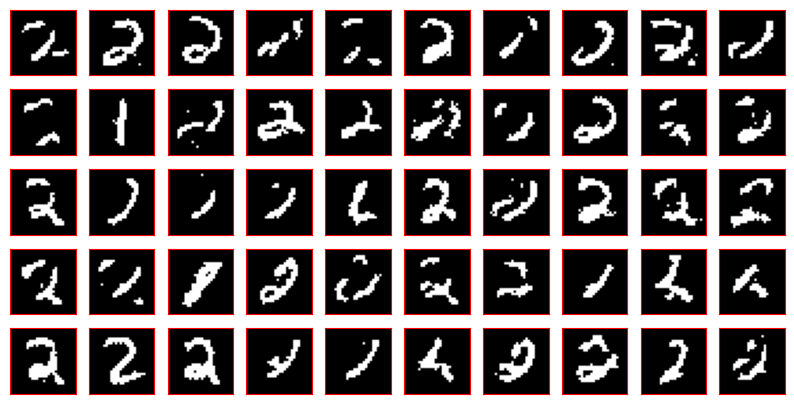

In [163]:
print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

### **3.2 EMNIST :**

Fonction pour sélectioner les images du jeu de données EMNIST, selon les caractères souhaités :

In [169]:
from emnist import extract_training_samples

def select_emnist_data(digits_list, limit_digit_samples=None):

    train_X, train_y = extract_training_samples('balanced')
    
    emnist_selected_data = []

    # Selecting the images corresponding to the desired digits
    for digit in digits_list:
        digit_data = list(train_X[train_y == digit])
        np.random.shuffle(digit_data)
        emnist_selected_data.extend(digit_data[:limit_digit_samples])

    # Flattening the images
    for i in range(len(emnist_selected_data)):
        emnist_selected_data[i] = (emnist_selected_data[i].flatten() > 128) * 1.0

    return np.array(emnist_selected_data)

#### **3.2.1 Apprentissage isolé des caractères “A”, “B” et “C”**

**Apprentissage du caractère "A"**

Epoch: 0     -   Loss: 43.2281
Epoch: 1     -   Loss: 33.1382
Epoch: 2     -   Loss: 28.0845
Epoch: 3     -   Loss: 26.1303
Epoch: 4     -   Loss: 23.3819
Epoch: 5     -   Loss: 21.7545
Epoch: 6     -   Loss: 20.3219
Epoch: 7     -   Loss: 19.0850
Epoch: 8     -   Loss: 18.0127
Epoch: 9     -   Loss: 16.8327
Epoch: 10    -   Loss: 15.8590
Epoch: 11    -   Loss: 15.0463
Epoch: 12    -   Loss: 14.3622
Epoch: 13    -   Loss: 14.0203
Epoch: 14    -   Loss: 13.3379
Epoch: 15    -   Loss: 12.8146
Epoch: 16    -   Loss: 12.2262
Epoch: 17    -   Loss: 11.5942
Epoch: 18    -   Loss: 11.2311
Epoch: 19    -   Loss: 10.6538
Epoch: 20    -   Loss: 10.2446
Epoch: 21    -   Loss: 9.9892
Epoch: 22    -   Loss: 9.5971
Epoch: 23    -   Loss: 9.1994
Epoch: 24    -   Loss: 8.9337
Epoch: 25    -   Loss: 8.7289
Epoch: 26    -   Loss: 8.3062
Epoch: 27    -   Loss: 7.9615
Epoch: 28    -   Loss: 7.7357
Epoch: 29    -   Loss: 7.4306
Epoch: 30    -   Loss: 7.1968
Epoch: 31    -   Loss: 7.0838
Epoch: 32    -   Lo

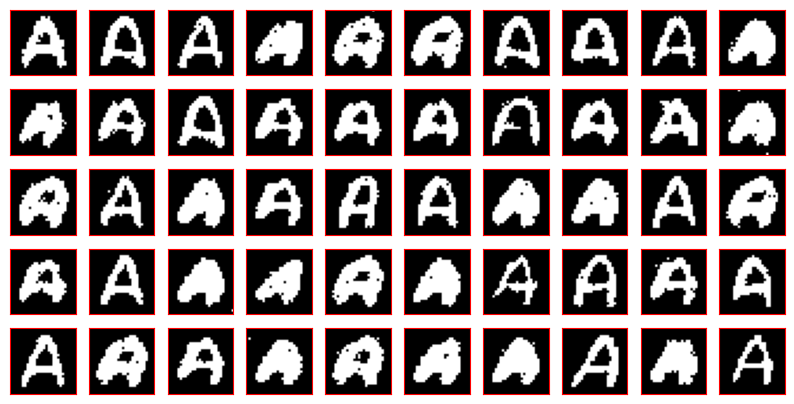

In [174]:
images = select_emnist_data([10], limit_digit_samples=1000)

my_rbm = RBM(784, 1250)

loss = my_rbm.train(images, lr=0.1, batch_size=50, nb_iter=200,
                    print_all_losses=True, plot_loss=False)

print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

**Apprentissage du caractère "B"**

Epoch: 0     -   Loss: 53.0741
Epoch: 1     -   Loss: 43.4407
Epoch: 2     -   Loss: 37.6734
Epoch: 3     -   Loss: 33.0250
Epoch: 4     -   Loss: 30.3017
Epoch: 5     -   Loss: 27.8431
Epoch: 6     -   Loss: 25.8172
Epoch: 7     -   Loss: 23.7294
Epoch: 8     -   Loss: 21.9876
Epoch: 9     -   Loss: 20.9867
Epoch: 10    -   Loss: 19.5917
Epoch: 11    -   Loss: 18.7480
Epoch: 12    -   Loss: 17.7078
Epoch: 13    -   Loss: 16.8378
Epoch: 14    -   Loss: 16.1687
Epoch: 15    -   Loss: 15.2962
Epoch: 16    -   Loss: 14.4485
Epoch: 17    -   Loss: 13.8515
Epoch: 18    -   Loss: 13.0821
Epoch: 19    -   Loss: 12.6210
Epoch: 20    -   Loss: 12.0246
Epoch: 21    -   Loss: 11.7405
Epoch: 22    -   Loss: 11.0993
Epoch: 23    -   Loss: 10.7614
Epoch: 24    -   Loss: 10.3061
Epoch: 25    -   Loss: 9.7522
Epoch: 26    -   Loss: 9.4741
Epoch: 27    -   Loss: 9.1961
Epoch: 28    -   Loss: 8.6037
Epoch: 29    -   Loss: 8.3463
Epoch: 30    -   Loss: 8.1801
Epoch: 31    -   Loss: 7.7928
Epoch: 32    - 

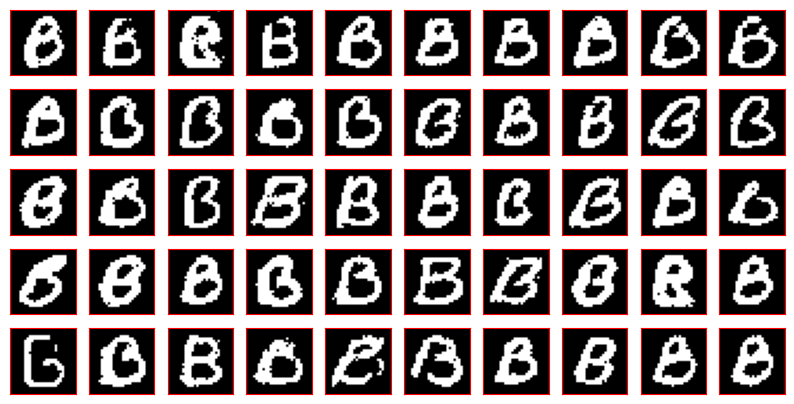

In [175]:
images = select_emnist_data([11], limit_digit_samples=1000)

my_rbm = RBM(784, 1250)

loss = my_rbm.train(images, lr=0.1, batch_size=50, nb_iter=200,
                    print_all_losses=True, plot_loss=False)

print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

**Apprentissage du caractère "C"**

Epoch: 0     -   Loss: 31.9545
Epoch: 1     -   Loss: 24.7215
Epoch: 2     -   Loss: 21.7615
Epoch: 3     -   Loss: 19.4653
Epoch: 4     -   Loss: 17.2549
Epoch: 5     -   Loss: 15.8562
Epoch: 6     -   Loss: 15.0377
Epoch: 7     -   Loss: 14.1127
Epoch: 8     -   Loss: 13.2916
Epoch: 9     -   Loss: 12.7813
Epoch: 10    -   Loss: 11.9466
Epoch: 11    -   Loss: 11.5159
Epoch: 12    -   Loss: 11.1515
Epoch: 13    -   Loss: 10.4120
Epoch: 14    -   Loss: 10.1979
Epoch: 15    -   Loss: 9.6956
Epoch: 16    -   Loss: 9.2011
Epoch: 17    -   Loss: 9.1684
Epoch: 18    -   Loss: 8.6415
Epoch: 19    -   Loss: 8.4416
Epoch: 20    -   Loss: 8.1363
Epoch: 21    -   Loss: 7.8034
Epoch: 22    -   Loss: 7.5619
Epoch: 23    -   Loss: 7.2845
Epoch: 24    -   Loss: 7.0145
Epoch: 25    -   Loss: 6.8520
Epoch: 26    -   Loss: 6.6667
Epoch: 27    -   Loss: 6.5524
Epoch: 28    -   Loss: 6.2137
Epoch: 29    -   Loss: 5.9807
Epoch: 30    -   Loss: 5.9025
Epoch: 31    -   Loss: 5.6820
Epoch: 32    -   Loss: 5.

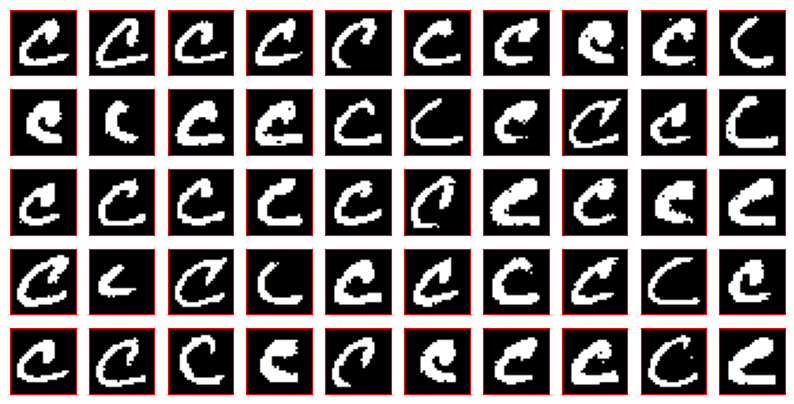

In [176]:
images = select_emnist_data([12], limit_digit_samples=1000)

my_rbm = RBM(784, 1250)

loss = my_rbm.train(images, lr=0.1, batch_size=50, nb_iter=200,
                    print_all_losses=True, plot_loss=False)

print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

#### **3.2.2 Apprentissage des groupes de caractères : {"A", "B"} et {"A", "C"}**

**Apprentissage des caractères "A" et "B"**

Epoch: 0     -   Loss: 55.5638
Epoch: 1     -   Loss: 45.9121
Epoch: 2     -   Loss: 38.9560
Epoch: 3     -   Loss: 34.9402
Epoch: 4     -   Loss: 31.8521
Epoch: 5     -   Loss: 29.8097
Epoch: 6     -   Loss: 27.9441
Epoch: 7     -   Loss: 26.1076
Epoch: 8     -   Loss: 25.3110
Epoch: 9     -   Loss: 23.6079
Epoch: 10    -   Loss: 22.5767
Epoch: 11    -   Loss: 21.4133
Epoch: 12    -   Loss: 20.5117
Epoch: 13    -   Loss: 19.7309
Epoch: 14    -   Loss: 18.7499
Epoch: 15    -   Loss: 18.0735
Epoch: 16    -   Loss: 17.5754
Epoch: 17    -   Loss: 16.9622
Epoch: 18    -   Loss: 16.3116
Epoch: 19    -   Loss: 15.6439
Epoch: 20    -   Loss: 15.1516
Epoch: 21    -   Loss: 14.6435
Epoch: 22    -   Loss: 14.1812
Epoch: 23    -   Loss: 13.9192
Epoch: 24    -   Loss: 13.4502
Epoch: 25    -   Loss: 12.9487
Epoch: 26    -   Loss: 12.4941
Epoch: 27    -   Loss: 12.2130
Epoch: 28    -   Loss: 11.9035
Epoch: 29    -   Loss: 11.6018
Epoch: 30    -   Loss: 11.1956
Epoch: 31    -   Loss: 10.8911
Epoch: 3

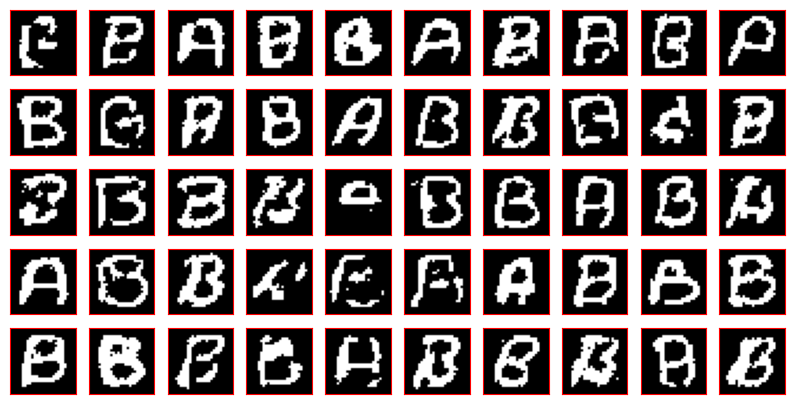

In [179]:
images = select_emnist_data([10,11], limit_digit_samples=1000)

my_rbm = RBM(784, 1250)

loss = my_rbm.train(images, lr=0.15, batch_size=100, nb_iter=250,
                    print_all_losses=True, plot_loss=False)

print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

**Apprentissage des caractères "B" et "C"**

Epoch: 0     -   Loss: 41.9979
Epoch: 1     -   Loss: 33.2138
Epoch: 2     -   Loss: 29.0248
Epoch: 3     -   Loss: 25.7715
Epoch: 4     -   Loss: 23.9125
Epoch: 5     -   Loss: 22.0675
Epoch: 6     -   Loss: 20.6888
Epoch: 7     -   Loss: 19.4267
Epoch: 8     -   Loss: 18.4746
Epoch: 9     -   Loss: 17.6641
Epoch: 10    -   Loss: 16.8308
Epoch: 11    -   Loss: 15.9469
Epoch: 12    -   Loss: 15.3128
Epoch: 13    -   Loss: 14.9465
Epoch: 14    -   Loss: 14.3035
Epoch: 15    -   Loss: 13.7173
Epoch: 16    -   Loss: 13.4242
Epoch: 17    -   Loss: 12.8438
Epoch: 18    -   Loss: 12.4390
Epoch: 19    -   Loss: 12.0886
Epoch: 20    -   Loss: 11.7528
Epoch: 21    -   Loss: 11.4370
Epoch: 22    -   Loss: 11.1092
Epoch: 23    -   Loss: 10.7516
Epoch: 24    -   Loss: 10.5700
Epoch: 25    -   Loss: 10.3144
Epoch: 26    -   Loss: 9.9436
Epoch: 27    -   Loss: 9.6314
Epoch: 28    -   Loss: 9.4677
Epoch: 29    -   Loss: 9.3396
Epoch: 30    -   Loss: 9.0677
Epoch: 31    -   Loss: 8.9011
Epoch: 32    -

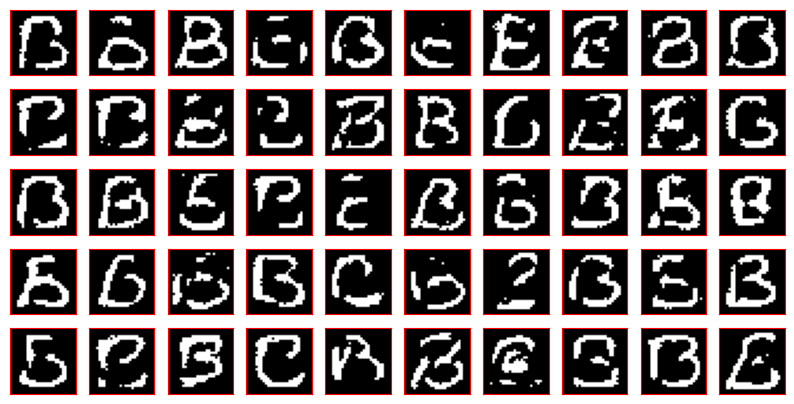

In [182]:
images = select_emnist_data([11,12], limit_digit_samples=1000)

my_rbm = RBM(784, 1250)

loss = my_rbm.train(images, lr=0.1, batch_size=100, nb_iter=250,
                    print_all_losses=True, plot_loss=False)

print("Perte finale : {:.4f}".format(loss[-1]))
print("Images générées :")
my_rbm.generer_image(100, 50, img_shape=(28,28))

## **4. Comparer les images générées avec celles produites par des architectures que vous auriez éventuellement déjà utilisés par le passé (ex : GAN, VAE, …, on pourra utiliser des librairies déjà existantes)**

### **4.1. Génération d’images à partir d’un GAN pré-entraîné :**

In [14]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import pylab
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
num_gpu = 1 if torch.cuda.is_available() else 0

# load the models
from auxiliary_files.dcgan import Generator

G = Generator(ngpu=1).eval()

# load weights
G.load_state_dict(torch.load('auxiliary_files/netG_epoch_99.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

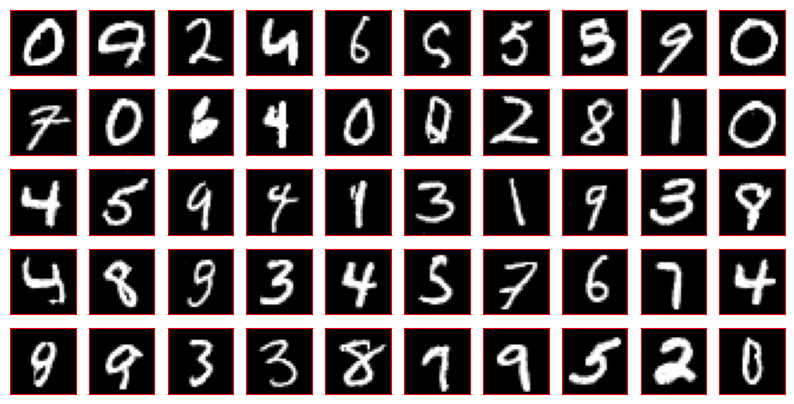

In [16]:
nb_images = 50
latent_size = 100

# Générér images
fixed_noise = torch.randn(nb_images, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

# Afficher images
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
plt.figure(figsize=(10,int(np.ceil(nb_images/10))))
for i in range(nb_images):
    plt.subplot(int(np.ceil(nb_images / 10)), 10, i+1)
    plt.imshow(fake_images_np[i], cmap='gray')
    ax = plt.gca()
    for i in ["top", "bottom", "left", "right"]:
        ax.spines[i].set_color("red")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### **4.2. Génération d’images à partir d’un VAE pré-entraîné :**

In [17]:
from __future__ import print_function
import argparse
import torch.utils.data
from torch import optim
from torch.nn import functional as F
from torchvision import datasets
from os.path import join as oj
import auxiliary_files.vae as vae
# plt.style.use('dark_background')
def to_im(x):
    return x.cpu().detach().numpy().reshape((28, 28))

In [18]:
net = vae.VAE()
net.load_state_dict(torch.load('auxiliary_files/vae_epoch_25.pth'))

<All keys matched successfully>

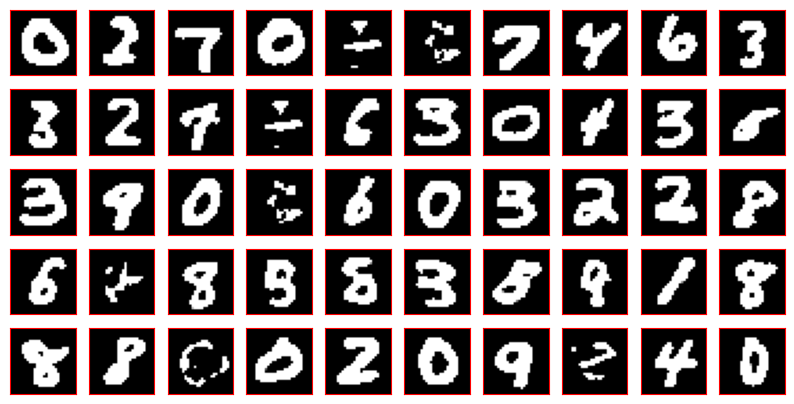

In [19]:
nb_images = 50

inds = np.random.choice(np.arange(60000), size=nb_images, replace=False)
dataset = datasets.MNIST(root='data', train=True, download=True)
ims = dataset.data[inds].float()

plt.figure(figsize=(10,int(np.ceil(nb_images/10))))
for i in range(nb_images):
    im_reconstructed = to_im(net(ims[i])[0])
    plt.subplot(int(np.ceil(nb_images / 10)), 10, i + 1)
    plt.imshow(im_reconstructed, cmap='gray')
    ax = plt.gca()
    for side in ["top", "bottom", "left", "right"]:
        ax.spines[side].set_color("red")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()